<a name="software-requirements"></a>
# Software Requirements

In [ ]:
%%bash
python -m pip install --upgrade pip
pip install git+https://github.com/ProfessorGuineapig/climate-learn.git

In [2]:
#After installing "rich", it is necessary to restart your runtime in order to ensure that all of the necessary components are properly loaded and running. 
!pip install -U rich

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.7/238.7 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: pygments
    Found existing installation: Pygments 2.6.1
    Uninstalling Pygments-2.6.1:
      Successfully uninstalled Pygments-2.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title # Loop over the years and download the data for each year  ERA5 { run: "auto" }
# Define the years list
from climate_learn.data import download1
years = []
for y in range(1995, 2023):
    years.append(str(y))

# Define the API key
api_key = "180713:7290f5d5-5abc-4f46-bd41-36c4eb380b4a" # Change to your_api_key

# Define the root directory for data downloads
root_dir = "/content/drive/MyDrive/Climate/.climate_tutorial"

# Define the dataset and variable to download



dataset = "era5"
variable = "2m_temperature"

#This method of selecting an area of interest can be seen here.: https://youtu.be/EIe7IBMqhsw
'''
The area list corresponds to the latitude and longitude boundaries of the region of interest in the xarray dataset.

The first and third elements of the area list correspond to the minimum and maximum latitude values of the region of interest, respectively. In this case, the minimum latitude is -5.2 and the maximum latitude is 31.

The second and fourth elements of the area list correspond to the minimum and maximum longitude values of the region of interest, respectively. In this case, the minimum longitude is 34 and the maximum longitude is 45.

The latitude and longitude coordinates in the xarray dataset should fall within these boundary values to be considered part of the region of interest.

'''


area = [58, -100, 42.5, -68.5]

resolution = str(0.5)

# Loop over the years and download the data for each year
for i, year in enumerate(years):
    #download_copernicus(root=root_dir, dataset=dataset, variable=variable, year=year, api_key=api_key)
    download1(root = root_dir, source = "copernicus", variable = variable, dataset = dataset, year = year, resolution=resolution, area=area, api_key = api_key)

In [ ]:
from climate_learn.utils.data import load_dataset, view
from climate_learn.data import download1

dataset = load_dataset("/content/drive/MyDrive/Climate/.climate_tutorial/data/copernicus/era5/0.5/2m_temperature")
view(dataset)

<xarray.Dataset>
Dimensions:    (longitude: 64, latitude: 32, time: 420768)
Coordinates:
  * longitude  (longitude) float32 -100.0 -99.5 -99.0 ... -69.5 -69.0 -68.5
  * latitude   (latitude) float32 58.0 57.5 57.0 56.5 ... 44.0 43.5 43.0 42.5
  * time       (time) datetime64[ns] 1975-01-01 ... 2022-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-03-12 05:50:51 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

train.py

<a name="temporal-forecasting"></a>
# Temporal Forecasting

## Data Preparation

Check out the [Data Processing Notebook](https://github.com/aditya-grover/climate-learn/tree/main/docs/notebooks/Data_Processing) for more info on this part.

In [3]:
from climate_learn.utils.data import load_dataset, view
from climate_learn.utils.datetime import Year, Days, Hours
from climate_learn.data.climate_dataset.args import ERA5Args
from climate_learn.data.tasks.args import ForecastingArgs
from climate_learn.data import download1, DataModuleArgs, DataModule

# Download data from weatherbench (~2-3 minutes)
#download1(root = "/content/drive/MyDrive/Climate/.climate_tutorial", source = "weatherbench", variable = "2m_temperature", dataset = "era5", resolution = "5.625")

#dataset = load_dataset("/content/drive/MyDrive/Climate/.climate_tutorial/era5/0.5/2m_temperature")
#view(dataset)

data_args = ERA5Args(
    root_dir = "/content/drive/MyDrive/Climate/.climate_tutorial/data/copernicus/era5/0.5/",
    variables = ["2m_temperature"],
    years = range(1975, 2022),
)

forecasting_args = ForecastingArgs(
    dataset_args = data_args,
    in_vars = ["2m_temperature"],
    out_vars = ["2m_temperature"],
    pred_range = 3*24,
    subsample = 6,
)

data_module_args = DataModuleArgs(
    task_args = forecasting_args,
    #train_start_year = 1975,
    train_start_year = 2015,
    val_start_year = 2016,
    test_start_year = 2017,
    deploy_start_year = None, #Add this line, which can be "None"
    end_year = 2022,
)

data_module = DataModule(
    data_module_args = data_module_args,
    batch_size = 128,
    num_workers = 1
)

Creating train dataset


100%|██████████| 1/1 [00:00<00:00, 35.81it/s]


Creating val dataset


100%|██████████| 1/1 [00:00<00:00, 42.46it/s]


Creating test dataset


100%|██████████| 6/6 [00:00<00:00, 55.52it/s]


In [4]:
data_module_args.test_start_year

2017

## Model initialization 

In [5]:
from climate_learn.models import load_model

model_kwargs = {
    "in_channels": len(data_module.hparams.data_module_args.train_task_args.in_vars),
    "out_channels": len(data_module.hparams.data_module_args.train_task_args.out_vars),
    "n_blocks": 4
}

# Only for Vit
"""model_kwargs = {
    "img_size":[32, 64],
    "patch_size":4,
    "drop_path":0.1,
    "drop_rate":0.1,
    "learn_pos_emb": False,
    "in_vars":[
        "2m_temperature",
        ],
    "out_vars":["2m_temperature"],
    "embed_dim":256,
    "depth":6,
    "decoder_depth":2,
    "num_heads":4,
    "mlp_ratio":1,
}"""

optim_kwargs = {
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "warmup_epochs": 1,
    "max_epochs": 5,
}

model_module = load_model(name = "resnet", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)
#model_module = load_model(name = "vit", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)
#model_module = load_model(name = "unet", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)

In [ ]:
from climate_learn.models import set_climatology
set_climatology(model_module, data_module)

## Training

In [ ]:
from climate_learn.training import Trainer

trainer = Trainer(
    seed = 0,
    accelerator = "gpu",
    #accelerator = "cpu",
    precision = 16,
    max_epochs = 4,
)

INFO:lightning_fabric.utilities.seed:Global seed set to 0
/usr/local/lib/python3.9/dist-packages/lightning_fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(


In [ ]:
trainer.fit(model_module, data_module)

Creating deploy dataset


100%|██████████| 4/4 [00:00<00:00, 26.78it/s]


Creating train dataset


100%|██████████| 40/40 [00:00<00:00, 50.66it/s]


Creating val dataset


100%|██████████| 3/3 [00:00<00:00, 34.88it/s]


Creating test dataset


100%|██████████| 5/5 [00:00<00:00, 46.01it/s]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name                       ┃ Type              ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ net                        │ ResNet            │  1.2 M │
│ 1  │ net.activation             │ LeakyReLU         │      0 │
│ 2  │ net.image_proj             │ PeriodicConv2D    │  6.4 K │
│ 3  │ net.image_proj.padding     │ PeriodicPadding2D │      0 │
│ 4  │ net.image_proj.conv        │ Conv2d            │  6.4 K │
│ 5  │ net.blocks                 │ ModuleList        │  1.2 M │
│ 6  │ net.blocks.0               │ ResidualBlock     │  295 K │
│ 7  │ net.blocks.0.activation    │ LeakyReLU         │      0 │
│ 8  │ net.blocks.0.conv1         │ PeriodicConv2D    │  147 K │
│ 9  │ net.blocks.0.conv1.padding │ PeriodicPadding2D │      0 │
│ 10 │ net.blocks.0.conv1.conv    │ Conv2d            │  147 K │
│ 11 │ net.blocks.0.conv2         │ PeriodicConv2D    │  147 K │
│ 12 │ net.blocks.0.conv2.padding │ PeriodicPadding2D │      0 │
│ 13 │ net.blocks.0.conv2.conv    │ Conv2d            │  147 K │
│ 14 │ net.blocks.0.shortcut      │ Identity          │      0 │
│ 15 │ net.blocks.0.norm1         │ BatchNorm2d       │    256 │
│ 16 │ net.blocks.0.norm2         │ BatchNorm2d       │    256 │
│ 17 │ net.blocks.0.drop          │ Dropout           │      0 │
│ 18 │ net.blocks.1               │ ResidualBlock     │  295 K │
│ 19 │ net.blocks.1.activation    │ LeakyReLU         │      0 │
│ 20 │ net.blocks.1.conv1         │ PeriodicConv2D    │  147 K │
│ 21 │ net.blocks.1.conv1.padding │ PeriodicPadding2D │      0 │
│ 22 │ net.blocks.1.conv1.conv    │ Conv2d            │  147 K │
│ 23 │ net.blocks.1.conv2         │ PeriodicConv2D    │  147 K │
│ 24 │ net.blocks.1.conv2.padding │ PeriodicPadding2D │      0 │
│ 25 │ net.blocks.1.conv2.conv    │ Conv2d            │  147 K │
│ 26 │ net.blocks.1.shortcut      │ Identity          │      0 │
│ 27 │ net.blocks.1.norm1         │ BatchNorm2d       │    256 │
│ 28 │ net.blocks.1.norm2         │ BatchNorm2d       │    256 │
│ 29 │ net.blocks.1.drop          │ Dropout           │      0 │
│ 30 │ net.blocks.2               │ ResidualBlock     │  295 K │
│ 31 │ net.blocks.2.activation    │ LeakyReLU         │      0 │
│ 32 │ net.blocks.2.conv1         │ PeriodicConv2D    │  147 K │
│ 33 │ net.blocks.2.conv1.padding │ PeriodicPadding2D │      0 │
│ 34 │ net.blocks.2.conv1.conv    │ Conv2d            │  147 K │
│ 35 │ net.blocks.2.conv2         │ PeriodicConv2D    │  147 K │
│ 36 │ net.blocks.2.conv2.padding │ PeriodicPadding2D │      0 │
│ 37 │ net.blocks.2.conv2.conv    │ Conv2d            │  147 K │
│ 38 │ net.blocks.2.shortcut      │ Identity          │      0 │
│ 39 │ net.blocks.2.norm1         │ BatchNorm2d       │    256 │
│ 40 │ net.blocks.2.norm2         │ BatchNorm2d       │    256 │
│ 41 │ net.blocks.2.drop          │ Dropout           │      0 │
│ 42 │ net.blocks.3               │ ResidualBlock     │  295 K │
│ 43 │ net.blocks.3.activation    │ LeakyReLU         │      0 │
│ 44 │ net.blocks.3.conv1         │ PeriodicConv2D    │  147 K │
│ 45 │ net.blocks.3.conv1.padding │ PeriodicPadding2D │      0 │
│ 46 │ net.blocks.3.conv1.conv    │ Conv2d            │  147 K │
│ 47 │ net.blocks.3.conv2         │ PeriodicConv2D    │  147 K │
│ 48 │ net.blocks.3.conv2.padding │ PeriodicPadding2D │      0 │
│ 49 │ net.blocks.3.conv2.conv    │ Conv2d            │  147 K │
│ 50 │ net.blocks.3.shortcut      │ Identity          │      0 │
│ 51 │ net.blocks.3.norm1         │ BatchNorm2d       │    256 │
│ 52 │ net.blocks.3.norm2         │ BatchNorm2d       │    256 │
│ 53 │ net.blocks.3.drop          │ Dropout           │      0 │
│ 54 │ net.norm                   │ BatchNorm2d       │    256 │
│ 55 │ net.final                  │ PeriodicConv2D    │  6.3 K │
│ 56 │ net.final.padding          │ PeriodicPadding2D │      0 │
│ 57 │ net.final.conv             │ Conv2d            │  6.3 K │
│ 58 │ denormalization            │

Trainable params: 1.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 4

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
model_module2 = load_model(name = "resnet", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)


In [ ]:
model_module.lat

array([58. , 57.5, 57. , 56.5, 56. , 55.5, 55. , 54.5, 54. , 53.5, 53. ,
       52.5, 52. , 51.5, 51. , 50.5, 50. , 49.5, 49. , 48.5, 48. , 47.5,
       47. , 46.5, 46. , 45.5, 45. , 44.5, 44. , 43.5, 43. , 42.5],
      dtype=float32)

In [ ]:
'''import torch

# Save model state_dict and denormalization layer information
torch.save({
    'model_state_dict': model_module.state_dict(),
    'denormalization_mean': model_module.denormalization.mean,
    'denormalization_std': model_module.denormalization.std,
    'pred_range': model_module.pred_range,
    'lat': model_module.lat,
    'test_clim': model_module.test_clim,
    'train_clim': model_module.train_clim
}, 'trained_model2.pth')'''

In [ ]:
import os
import torch

#The specific file for saving the trained model has been created and is ready to be reused. 
save_dir = "/content/drive/MyDrive/Climate/.climate_tutorial/trained model/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

save_path = "/content/drive/MyDrive/Climate/.climate_tutorial/trained model/trained_model.pth" #When saving your work, it is important to remember to choose a unique file name.  
# Save model state_dict and denormalization layer information
torch.save({
    'model_state_dict': model_module.state_dict(),
    'denormalization_mean': model_module.denormalization.mean,
    'denormalization_std': model_module.denormalization.std,
    'pred_range': model_module.pred_range,
    'lat': model_module.lat,
    'test_clim': model_module.test_clim,
    'train_clim': model_module.train_clim
}, save_path)


In [ ]:
"""import torch
from torchvision.transforms import Normalize

save_path = "/content/drive/MyDrive/Climate/.climate_tutorial/trained model/trained_model0319.pth"

# Load the state_dict and denormalization layer information
checkpoint = torch.load(save_path)
model_state_dict = checkpoint['model_state_dict']
denormalization_mean = checkpoint['denormalization_mean']
denormalization_std = checkpoint['denormalization_std']
pred_range = checkpoint['pred_range']
lat = checkpoint['lat']
test_clim = checkpoint['test_clim']
train_clim = checkpoint['train_clim']

# Update the model_module2 with the loaded state_dict
model_module2.load_state_dict(model_state_dict)
model_module2.pred_range = pred_range
model_module2.lat = lat
model_module2.test_clim = test_clim
model_module2.train_clim = train_clim

# Recreate the denormalization layer using the saved mean and standard deviation
model_module2.denormalization = Normalize(mean=denormalization_mean, std=denormalization_std)"""

In [ ]:
from climate_learn.models import fit_lin_reg_baseline
fit_lin_reg_baseline(model_module2, data_module, reg_hparam=0.0)

In [ ]:
#trainer.fit(model_module, data_module)

Creating deploy dataset


100%|██████████| 2/2 [00:00<00:00, 42.69it/s]


Creating train dataset


100%|██████████| 4/4 [00:00<00:00, 35.12it/s]


Creating val dataset


100%|██████████| 1/1 [00:00<00:00, 32.49it/s]


Creating test dataset


100%|██████████| 3/3 [00:00<00:00, 34.92it/s]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name                       ┃ Type              ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ net                        │ ResNet            │  1.2 M │
│ 1  │ net.activation             │ LeakyReLU         │      0 │
│ 2  │ net.image_proj             │ PeriodicConv2D    │  6.4 K │
│ 3  │ net.image_proj.padding     │ PeriodicPadding2D │      0 │
│ 4  │ net.image_proj.conv        │ Conv2d            │  6.4 K │
│ 5  │ net.blocks                 │ ModuleList        │  1.2 M │
│ 6  │ net.blocks.0               │ ResidualBlock     │  295 K │
│ 7  │ net.blocks.0.activation    │ LeakyReLU         │      0 │
│ 8  │ net.blocks.0.conv1         │ PeriodicConv2D    │  147 K │
│ 9  │ net.blocks.0.conv1.padding │ PeriodicPadding2D │      0 │
│ 10 │ net.blocks.0.conv1.conv    │ Conv2d            │  147 K │
│ 11 │ net.blocks.0.conv2         │ PeriodicConv2D    │  147 K │
│ 12 │ net.blocks.0.conv2.padding │ PeriodicPadding2D │      0 │
│ 13 │ net.blocks.0.conv2.conv    │ Conv2d            │  147 K │
│ 14 │ net.blocks.0.shortcut      │ Identity          │      0 │
│ 15 │ net.blocks.0.norm1         │ BatchNorm2d       │    256 │
│ 16 │ net.blocks.0.norm2         │ BatchNorm2d       │    256 │
│ 17 │ net.blocks.0.drop          │ Dropout           │      0 │
│ 18 │ net.blocks.1               │ ResidualBlock     │  295 K │
│ 19 │ net.blocks.1.activation    │ LeakyReLU         │      0 │
│ 20 │ net.blocks.1.conv1         │ PeriodicConv2D    │  147 K │
│ 21 │ net.blocks.1.conv1.padding │ PeriodicPadding2D │      0 │
│ 22 │ net.blocks.1.conv1.conv    │ Conv2d            │  147 K │
│ 23 │ net.blocks.1.conv2         │ PeriodicConv2D    │  147 K │
│ 24 │ net.blocks.1.conv2.padding │ PeriodicPadding2D │      0 │
│ 25 │ net.blocks.1.conv2.conv    │ Conv2d            │  147 K │
│ 26 │ net.blocks.1.shortcut      │ Identity          │      0 │
│ 27 │ net.blocks.1.norm1         │ BatchNorm2d       │    256 │
│ 28 │ net.blocks.1.norm2         │ BatchNorm2d       │    256 │
│ 29 │ net.blocks.1.drop          │ Dropout           │      0 │
│ 30 │ net.blocks.2               │ ResidualBlock     │  295 K │
│ 31 │ net.blocks.2.activation    │ LeakyReLU         │      0 │
│ 32 │ net.blocks.2.conv1         │ PeriodicConv2D    │  147 K │
│ 33 │ net.blocks.2.conv1.padding │ PeriodicPadding2D │      0 │
│ 34 │ net.blocks.2.conv1.conv    │ Conv2d            │  147 K │
│ 35 │ net.blocks.2.conv2         │ PeriodicConv2D    │  147 K │
│ 36 │ net.blocks.2.conv2.padding │ PeriodicPadding2D │      0 │
│ 37 │ net.blocks.2.conv2.conv    │ Conv2d            │  147 K │
│ 38 │ net.blocks.2.shortcut      │ Identity          │      0 │
│ 39 │ net.blocks.2.norm1         │ BatchNorm2d       │    256 │
│ 40 │ net.blocks.2.norm2         │ BatchNorm2d       │    256 │
│ 41 │ net.blocks.2.drop          │ Dropout           │      0 │
│ 42 │ net.blocks.3               │ ResidualBlock     │  295 K │
│ 43 │ net.blocks.3.activation    │ LeakyReLU         │      0 │
│ 44 │ net.blocks.3.conv1         │ PeriodicConv2D    │  147 K │
│ 45 │ net.blocks.3.conv1.padding │ PeriodicPadding2D │      0 │
│ 46 │ net.blocks.3.conv1.conv    │ Conv2d            │  147 K │
│ 47 │ net.blocks.3.conv2         │ PeriodicConv2D    │  147 K │
│ 48 │ net.blocks.3.conv2.padding │ PeriodicPadding2D │      0 │
│ 49 │ net.blocks.3.conv2.conv    │ Conv2d            │  147 K │
│ 50 │ net.blocks.3.shortcut      │ Identity          │      0 │
│ 51 │ net.blocks.3.norm1         │ BatchNorm2d       │    256 │
│ 52 │ net.blocks.3.norm2         │ BatchNorm2d       │    256 │
│ 53 │ net.blocks.3.drop          │ Dropout           │      0 │
│ 54 │ net.norm                   │ BatchNorm2d       │    256 │
│ 55 │ net.final                  │ PeriodicConv2D    │  6.3 K │
│ 56 │ net.final.padding          │ PeriodicPadding2D │      0 │
│ 57 │ net.final.conv             │ Conv2d            │  6.3 K │
│ 58 │ denormalization            │

Trainable params: 1.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 4

Output()

## Evaluation 


In [ ]:
trainer.test(model_module, data_module)

Creating deploy dataset


100%|██████████| 4/4 [00:00<00:00, 47.85it/s]


Creating train dataset


100%|██████████| 40/40 [00:00<00:00, 51.61it/s]


Creating val dataset


100%|██████████| 3/3 [00:00<00:00, 48.68it/s]


Creating test dataset


100%|██████████| 5/5 [00:00<00:00, 49.41it/s]
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                        test/acc                        │                   0.4750738739967346                   │
│            test/acc_2m_temperature_3.0_days            │                   0.4750738739967346                   │
│                      test/w_rmse                       │                   5.162153244018555                    │
│          test/w_rmse_2m_temperature_3.0_days           │                   5.162153244018555                    │
│            test_climatology_baseline/w_rmse            │                   11.904684066772461                   │
│ test_climatology_baseline/w_rmse_2m_temperature_3.0_d… │                   11.904684066772461                   │
│            test_persistence_baseline/w_rmse            │                   6.215463638305664                    │
│ test_persistence_baseline/w_rmse_2m_temperature_3.0_d… │                   6.215463638305664                    │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

In [ ]:
trainer.test(model_module2, data_module)

Creating deploy dataset


100%|██████████| 2/2 [00:00<00:00, 29.12it/s]


Creating train dataset


100%|██████████| 4/4 [00:00<00:00, 33.92it/s]


Creating val dataset


100%|██████████| 1/1 [00:00<00:00, 38.88it/s]


Creating test dataset


100%|██████████| 3/3 [00:00<00:00, 45.79it/s]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                        test/acc                        │                   0.3888242542743683                   │
│            test/acc_2m_temperature_3.0_days            │                   0.3888242542743683                   │
│                      test/w_rmse                       │                   5.845704078674316                    │
│          test/w_rmse_2m_temperature_3.0_days           │                   5.845704078674316                    │
│            test_climatology_baseline/w_rmse            │                   11.770124435424805                   │
│ test_climatology_baseline/w_rmse_2m_temperature_3.0_d… │                   11.770124435424805                   │
│            test_persistence_baseline/w_rmse            │                   6.305548191070557                    │
│ test_persistence_baseline/w_rmse_2m_temperature_3.0_d… │                   6.305548191070557                    │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

This visualization displays the results of a random test for the Resnet model. It shows the weather forecast for the temperature of the selected region (area = [58, -100, 42.5, -68.5]) in a short time period (3 days). The initial condition is the temperature of the date we selected to test, the ground truth is the actual temperature after 3 days, and the prediction is the outcome of the trained model. 

The mean square error of the Resnet model is relatively high, but its small size of less than 5MB makes it easy to deploy. This is a major advantage of the Resnet model, as it can be used in a variety of applications without taking up too much space.

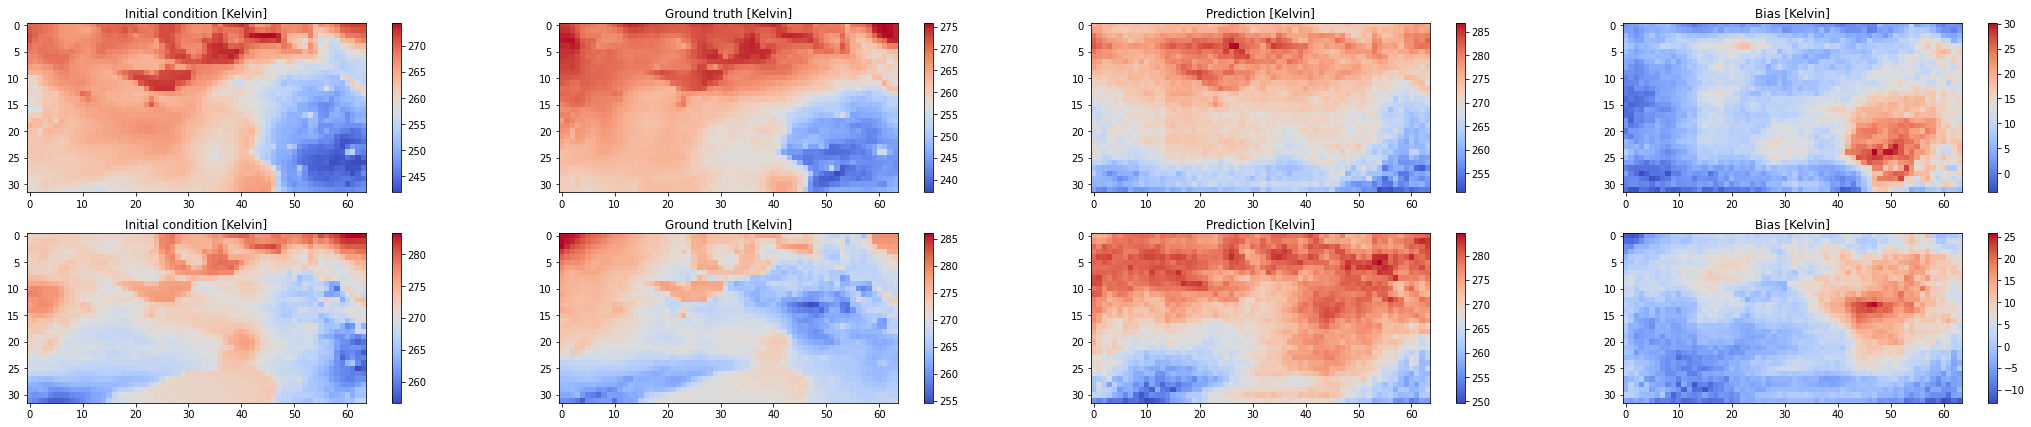

In [ ]:
from climate_learn.utils import visualize

# if samples = 2, we randomly pick 2 initial conditions in the test set
visualize(model_module2, data_module, samples = 2)

The visualization belowshows the results of a random test for the trained Unet model. Although the model has a slightly lower mean square error, its size is quite large, almost 1GB, which makes it unlikely to be deployed for our course project.

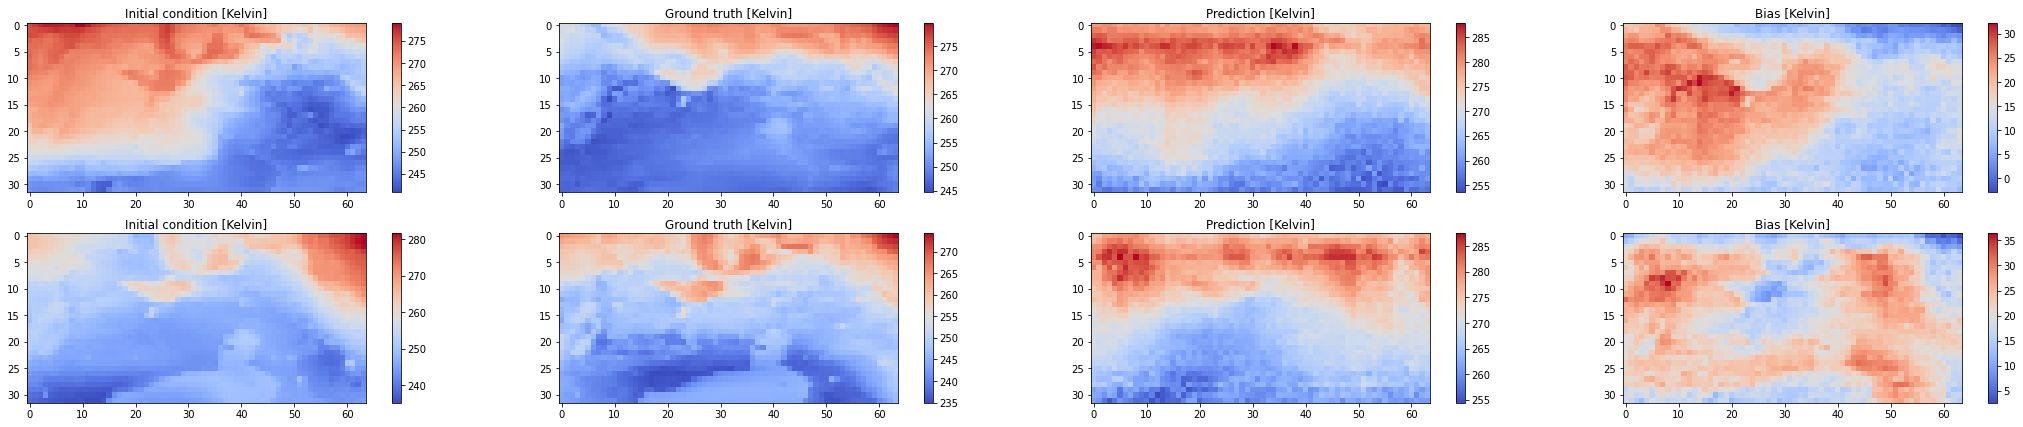

In [ ]:
from climate_learn.utils import visualize

# if samples = 2, we randomly pick 2 initial conditions in the test set
visualize(model_module, data_module, samples = ["2018-06-01:12", "2018-08-01:18"])

<a name="spatial-downscaling"></a>
# Spatial Downscaling

## Data Preparation

In [ ]:
from climate_learn.utils.datetime import Year, Days, Hours
from climate_learn.data.climate_dataset.args import ERA5Args
from climate_learn.data.tasks.args import DownscalingArgs
from climate_learn.data import download, DataModuleArgs, DataModule

# Download data from weatherbench (~4-6 minutes)
download(root = "/content/drive/MyDrive/Climate/.climate_tutorial", source = "weatherbench", variable = "2m_temperature", dataset = "era5", resolution = "2.8125")

lowres_data_args = ERA5Args(
    root_dir = "/content/drive/MyDrive/Climate/.climate_tutorial/data/weatherbench/era5/5.625/",
    variables = ["2m_temperature"],
    years = range(1979, 2015),
)

highres_data_args = ERA5Args(
    root_dir = "/content/drive/MyDrive/Climate/.climate_tutorial/data/weatherbench/era5/2.8125",
    variables = ["2m_temperature"],
    years = range(1979, 2015),
)

downscaling_args = DownscalingArgs(
    dataset_args = data_args,
    highres_dataset_args = highres_data_args,
    in_vars = ["2m_temperature"],
    out_vars = ["2m_temperature"],
    subsample = 6,
)

data_module_args = DataModuleArgs(
    task_args = downscaling_args,
    train_start_year = 1979,
    val_start_year = 2015,
    test_start_year = 2017,
    end_year = 2018,
)

data_module = DataModule(
    data_module_args = data_module_args,
    batch_size = 128,
    num_workers = 1
)

Creating train dataset


100%|██████████| 1/1 [00:00<00:00, 30.77it/s]


Creating val dataset


100%|██████████| 1/1 [00:00<00:00, 26.84it/s]


Creating test dataset


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


## Model initialization

In [ ]:
from climate_learn.models import load_model
from torch.optim import AdamW

model_kwargs = {
    "in_channels": len(data_module.hparams.data_module_args.train_task_args.in_vars),
    "out_channels": len(data_module.hparams.data_module_args.train_task_args.out_vars),
    "n_blocks": 4,
}

optim_kwargs = {
    "optimizer": AdamW,
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "warmup_epochs": 1,
    "max_epochs": 5,
}

model_module = load_model(name = "resnet", task = "downscaling", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)

In [ ]:
# latitude long info, 
from climate_learn.models import set_climatology
set_climatology(model_module, data_module)

## Training

In [ ]:
from climate_learn.training import Trainer

trainer = Trainer(
    seed = 0,
    accelerator = "gpu",
    precision = 16,
    max_epochs = 5,
)

INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [ ]:
trainer.fit(model_module, data_module)

/usr/local/lib/python3.8/dist-packages/lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name                       ┃ Type              ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ net                        │ ResNet            │  1.2 M │
│ 1  │ net.activation             │ LeakyReLU         │      0 │
│ 2  │ net.image_proj             │ PeriodicConv2D    │  6.4 K │
│ 3  │ net.image_proj.padding     │ PeriodicPadding2D │      0 │
│ 4  │ net.image_proj.conv        │ Conv2d            │  6.4 K │
│ 5  │ net.blocks                 │ ModuleList        │  1.2 M │
│ 6  │ net.blocks.0               │ ResidualBlock     │  295 K │
│ 7  │ net.blocks.0.activation    │ LeakyReLU         │      0 │
│ 8  │ net.blocks.0.conv1         │ PeriodicConv2D    │  147 K │
│ 9  │ net.blocks.0.conv1.padding │ PeriodicPadding2D │      0 │
│ 10 │ net.blocks.0.conv1.conv    │ Conv2d            │  147 K │
│ 11 │ net.blocks.0.conv2         │ PeriodicConv2D    │  147 K │
│ 12 │ net.blocks.0.conv2.padding │ PeriodicPadding2D │      0 │
│ 13 │ net.blocks.0.conv2.conv    │ Conv2d            │  147 K │
│ 14 │ net.blocks.0.shortcut      │ Identity          │      0 │
│ 15 │ net.blocks.0.norm1         │ BatchNorm2d       │    256 │
│ 16 │ net.blocks.0.norm2         │ BatchNorm2d       │    256 │
│ 17 │ net.blocks.0.drop          │ Dropout           │      0 │
│ 18 │ net.blocks.1               │ ResidualBlock     │  295 K │
│ 19 │ net.blocks.1.activation    │ LeakyReLU         │      0 │
│ 20 │ net.blocks.1.conv1         │ PeriodicConv2D    │  147 K │
│ 21 │ net.blocks.1.conv1.padding │ PeriodicPadding2D │      0 │
│ 22 │ net.blocks.1.conv1.conv    │ Conv2d            │  147 K │
│ 23 │ net.blocks.1.conv2         │ PeriodicConv2D    │  147 K │
│ 24 │ net.blocks.1.conv2.padding │ PeriodicPadding2D │      0 │
│ 25 │ net.blocks.1.conv2.conv    │ Conv2d            │  147 K │
│ 26 │ net.blocks.1.shortcut      │ Identity          │      0 │
│ 27 │ net.blocks.1.norm1         │ BatchNorm2d       │    256 │
│ 28 │ net.blocks.1.norm2         │ BatchNorm2d       │    256 │
│ 29 │ net.blocks.1.drop          │ Dropout           │      0 │
│ 30 │ net.blocks.2               │ ResidualBlock     │  295 K │
│ 31 │ net.blocks.2.activation    │ LeakyReLU         │      0 │
│ 32 │ net.blocks.2.conv1         │ PeriodicConv2D    │  147 K │
│ 33 │ net.blocks.2.conv1.padding │ PeriodicPadding2D │      0 │
│ 34 │ net.blocks.2.conv1.conv    │ Conv2d            │  147 K │
│ 35 │ net.blocks.2.conv2         │ PeriodicConv2D    │  147 K │
│ 36 │ net.blocks.2.conv2.padding │ PeriodicPadding2D │      0 │
│ 37 │ net.blocks.2.conv2.conv    │ Conv2d            │  147 K │
│ 38 │ net.blocks.2.shortcut      │ Identity          │      0 │
│ 39 │ net.blocks.2.norm1         │ BatchNorm2d       │    256 │
│ 40 │ net.blocks.2.norm2         │ BatchNorm2d       │    256 │
│ 41 │ net.blocks.2.drop          │ Dropout           │      0 │
│ 42 │ net.blocks.3               │ ResidualBlock     │  295 K │
│ 43 │ net.blocks.3.activation    │ LeakyReLU         │      0 │
│ 44 │ net.blocks.3.conv1         │ PeriodicConv2D    │  147 K │
│ 45 │ net.blocks.3.conv1.padding │ PeriodicPadding2D │      0 │
│ 46 │ net.blocks.3.conv1.conv    │ Conv2d            │  147 K │
│ 47 │ net.blocks.3.conv2         │ PeriodicConv2D    │  147 K │
│ 48 │ net.blocks.3.conv2.padding │ PeriodicPadding2D │      0 │
│ 49 │ net.blocks.3.conv2.conv    │ Conv2d            │  147 K │
│ 50 │ net.blocks.3.shortcut      │ Identity          │      0 │
│ 51 │ net.blocks.3.norm1         │ BatchNorm2d       │    256 │
│ 52 │ net.blocks.3.norm2         │ BatchNorm2d       │    256 │
│ 53 │ net.blocks.3.drop          │ Dropout           │      0 │
│ 54 │ net.norm                   │ BatchNorm2d       │    256 │
│ 55 │ net.final                  │ PeriodicConv2D    │  6.3 K │
│ 56 │ net.final.padding          │ PeriodicPadding2D │      0 │
│ 57 │ net.final.conv             │ Conv2d            │  6.3 K │
│ 58 │ denormalization            │

Trainable params: 1.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 2

Output()

## Evaluation

In [ ]:
trainer.test(model_module, data_module)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test/mean_bias_2m_temperature │      -0.6033839583396912      │
│ test/pearsonr_2m_temperature  │      0.9910030555527313       │
│   test/rmse_2m_temperature    │       2.859203577041626       │
└───────────────────────────────┴───────────────────────────────┘